# Variational Autoencoder (VAE)

Useful links: 
* original paper http://arxiv.org/abs/1312.6114
* helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this seminalr we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [5]:
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset()


images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [6]:
import numpy as np
X_train = data[:10000].reshape((10000,-1))
print(X_train.shape)
X_val = data[10000:].reshape((-1,X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [7]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

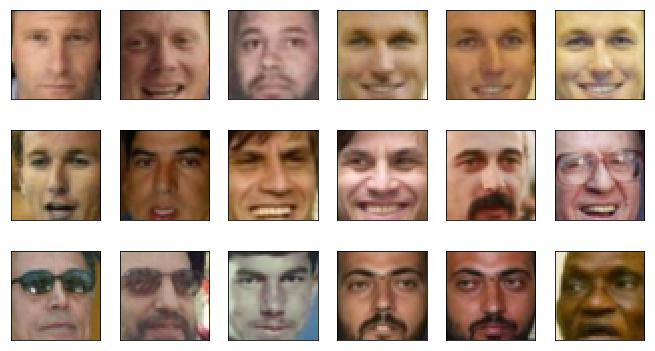

In [9]:
plot_gallery(X_train, image_h, image_w)

In [10]:
import theano
import theano.tensor as T

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [11]:
import lasagne

input_X = T.matrix("X")

input_shape = [None,image_h*image_w*3]

In [81]:
class Model(object):
    def __init__(self, HU_encoder=2000, HU_decoder=2000, dimZ=1000):
        self.HU_encoder = HU_encoder #you can play with this values
        self.HU_decoder = HU_decoder
        self.dimZ = dimZ #considering face reconstruction task, which size of representation seems reasonable?

        # define the network
        # use ReLU for hidden layers' activations
        # GlorotUniform initialization for W
        # zero initialization for biases
        # it's also convenient to put sigmoid activation on output layer to get nice normalized pics

        self.l_input = lasagne.layers.InputLayer(shape=input_shape, input_var=input_X) 
        self.l_enc = lasagne.layers.DenseLayer(self.l_input,num_units=self.HU_encoder,
                                           nonlinearity = lasagne.nonlinearities.rectify,
                                           W=lasagne.init.GlorotUniform(), b=lasagne.init.Constant(0.),    
                                           name = "hidden_encoder")
        self.l_z = lasagne.layers.DenseLayer(self.l_enc,num_units=self.dimZ,
                                           nonlinearity = lasagne.nonlinearities.rectify,
                                           W=lasagne.init.GlorotUniform(), b=lasagne.init.Constant(0.),    
                                           name = "hidden_representation")
        self.l_dec = lasagne.layers.DenseLayer(self.l_z,num_units=self.HU_decoder,
                                           nonlinearity = lasagne.nonlinearities.rectify,
                                           W=lasagne.init.GlorotUniform(), b=lasagne.init.Constant(0.),    
                                           name = "hidden_decoder")
        self.l_out = lasagne.layers.DenseLayer(self.l_dec,num_units=input_shape[1],
                                           nonlinearity = lasagne.nonlinearities.sigmoid,
                                           W=lasagne.init.GlorotUniform(), b=lasagne.init.Constant(0.),    
                                           name = "output")

        # create prediction variable
        self.prediction = lasagne.layers.get_output(self.l_out)

        # create loss function
        self.loss = lasagne.objectives.squared_error(self.prediction, input_X).mean()

        # create parameter update expressions
        self.params = lasagne.layers.get_all_params(self.l_out, trainable=True)
        self.updates = lasagne.updates.adam(self.loss, self.params, learning_rate=0.001)

        # compile training function that updates parameters and returns training loss
        # this will take a while
        self.train_fn = theano.function([input_X], self.loss, updates=self.updates)
        self.test_fn = theano.function([input_X], self.prediction)
        self.val_fn = theano.function([input_X], self.loss)

In [82]:
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [154]:
import time
from IPython.display import clear_output

def train_model(num_epochs, batch_size, model, func=None):
    if func is None:
        func = lambda x: x
    tl = []
    vl = []
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for index, batch in enumerate(iterate_minibatches(X_train, batch_size)):
            # print('batch_num=', index)
            inputs = batch
            train_err_batch = model.train_fn(inputs)
            train_err += train_err_batch
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, batch_size):
            inputs = batch
            val_err += model.val_fn(inputs)
            val_batches += 1


        # Then we print the results for this epoch:
        clear_output()
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))

        print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss (in-iteration):\t\t{:.6f}".format(val_err / val_batches))
        tl.append(func(train_err / train_batches))
        vl.append(func(val_err / val_batches))

        ind = np.random.randint(X_val.shape[0])
        pred = model.test_fn([X_val[ind]])

        plt.figure(figsize=(16, 10))
        ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=2)
        ax2 = plt.subplot2grid((3, 4), (0, 2), colspan=2)
        ax3 = plt.subplot2grid((3, 4), (1, 0), colspan=4, rowspan=2)

        ax1.imshow(X_val[ind].reshape((image_h, image_w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        ax2.imshow(pred.reshape((image_h, image_w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')

        ax3.plot(tl, c='orange', alpha=0.5, lw=2)
        ax3.plot(vl, c='b', alpha=0.5, lw=2)
        ax3.grid(True)
        ax3.set_title("Loss", fontsize=20)
        ax3.set_xlabel("Number of iteration", fontsize=16)
        ax3.set_ylabel("Loss", fontsize=16)
        ax3.legend(('Train loss', 'Validation loss'), loc=0, fontsize=16);
        plt.show()
    return model

Epoch 100 of 100 took 1.405s
  training loss (in-iteration):		0.004577
  validation loss (in-iteration):		0.004631


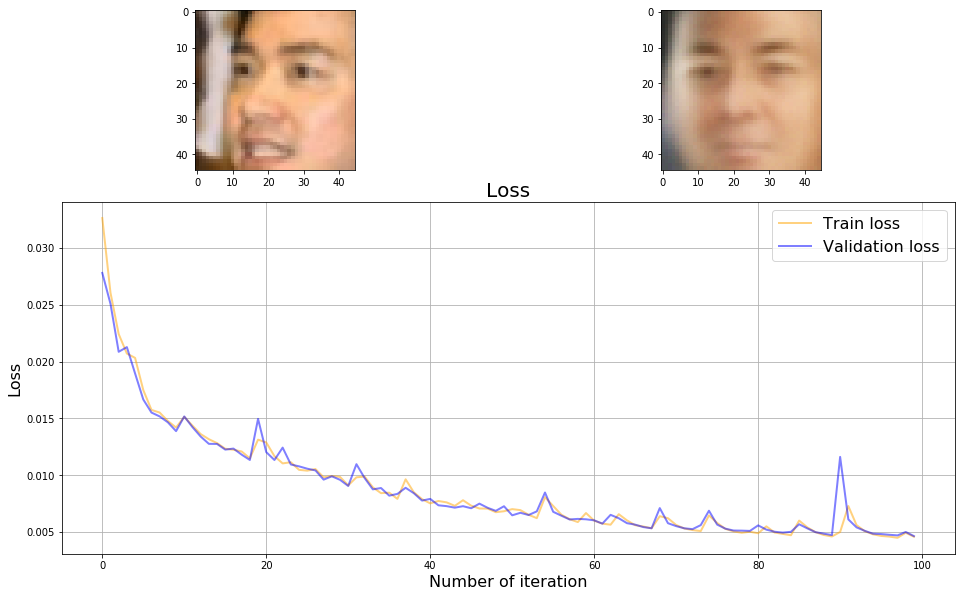

In [253]:
model_params = {'HU_encoder': 2000, 'HU_decoder': 2000, 'dimZ': 1000}

num_epochs = 100
batch_size = 1000

ae_model = train_model(num_epochs=num_epochs, batch_size=batch_size, model=Model(**model_params))

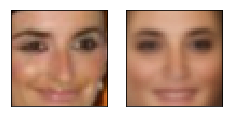

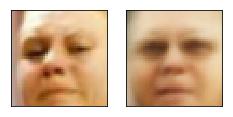

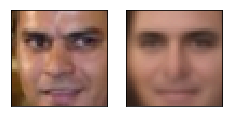

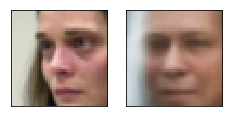

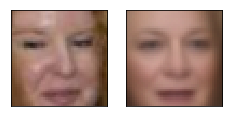

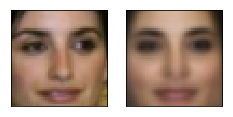

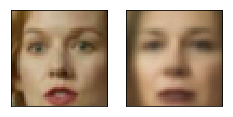

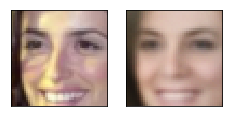

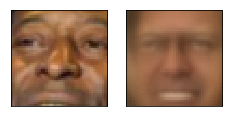

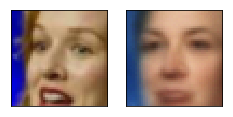

In [254]:
for batch in iterate_minibatches(X_val[:10], 1):
    pred = ae_model.test_fn(batch)
    plot_gallery([batch[0],pred], image_h, image_w, n_row=1, n_col=2)

# Sampling

This task requires deeper Lasagne knowledge. You need to perform inference from $z$, reconstruct an image given some random $z$ representations.

In [255]:
class Decoder(object):
    def __init__(self, model):
        self.HU_encoder = model.HU_encoder #you can play with this values
        self.HU_decoder = model.HU_decoder
        self.dimZ = model.dimZ #considering face reconstruction task, which size of representation seems reasonable?
        z_sample = T.matrix()

        # define the network
        # use ReLU for hidden layers' activations
        # GlorotUniform initialization for W
        # zero initialization for biases
        # it's also convenient to put sigmoid activation on output layer to get nice normalized pics
        self.l_z = lasagne.layers.InputLayer(shape=[None, model.l_z.num_units], input_var=z_sample)
        self.l_dec = lasagne.layers.DenseLayer(self.l_z,num_units=self.HU_decoder,
                                           nonlinearity = lasagne.nonlinearities.rectify,
                                           W=model.l_dec.W, b=model.l_dec.b,    
                                           name = "hidden_decoder")
        self.l_out = lasagne.layers.DenseLayer(self.l_dec,num_units=input_shape[1],
                                           nonlinearity = lasagne.nonlinearities.sigmoid,
                                           W=model.l_out.W, b=model.l_out.b,    
                                           name = "output")

        # create prediction variable
        self.prediction = lasagne.layers.get_output(self.l_out)
        self.gen_fn = theano.function([z_sample], self.prediction)

In [256]:
decoder = Decoder(ae_model)

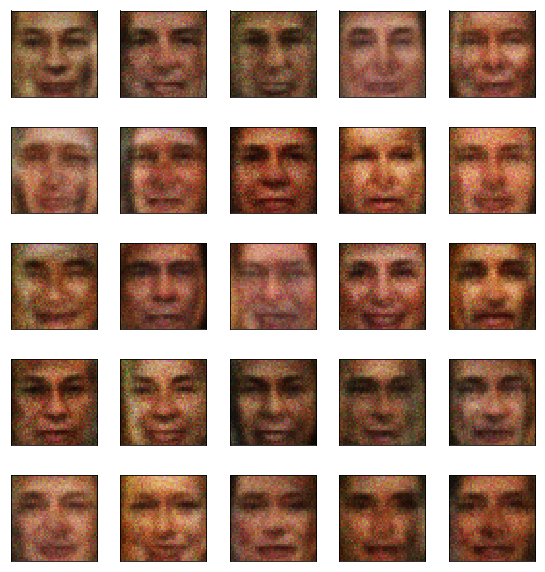

In [257]:
z = np.random.randn(25, dimZ)*0.5
output = decoder.gen_fn(np.asarray(z, dtype=theano.config.floatX))
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

Can you visualize how the distribution of $z$ looks like? Is it dense? What properties would we expect from it? Can we perform interpolation in $z$ space?

In [498]:
class Encoder(object):
    def __init__(self, model):
        self.HU_encoder = model.HU_encoder #you can play with this values
        self.HU_decoder = model.HU_decoder
        self.dimZ = model.dimZ #considering face reconstruction task, which size of representation seems reasonable?
        z_sample = T.matrix()

        rec_shift = lambda a: \
                    lasagne.nonlinearities.rectify(a + self.relu_shift) - \
                    self.relu_shift
        # define the network
        # use ReLU for hidden layers' activations
        # GlorotUniform initialization for W
        # zero initialization for biases
        # it's also convenient to put sigmoid activation on output layer to get nice normalized pics

        self.l_input = lasagne.layers.InputLayer(shape=input_shape, input_var=input_X) 
        self.l_enc = lasagne.layers.DenseLayer(self.l_input,num_units=self.HU_encoder,
                                           nonlinearity=lasagne.nonlinearities.rectify,
                                           W=model.l_enc.W, b=model.l_enc.b,    
                                           name = "encoder")
        if isinstance(model, Model):
            layer = model.l_z
        else:
            layer = model.l_mu
        self.l_mu = lasagne.layers.DenseLayer(self.l_enc,num_units=self.dimZ,
                                           nonlinearity=None,
                                           W=layer.W, b=layer.b,
                                           name = "mu")

        # create prediction variable
        self.prediction = lasagne.layers.get_output(self.l_mu)
        self.gen_fn = theano.function([input_X], self.prediction)

In [518]:
import seaborn as sns
sns.set('talk')

Посмотрим на первые пять признаков

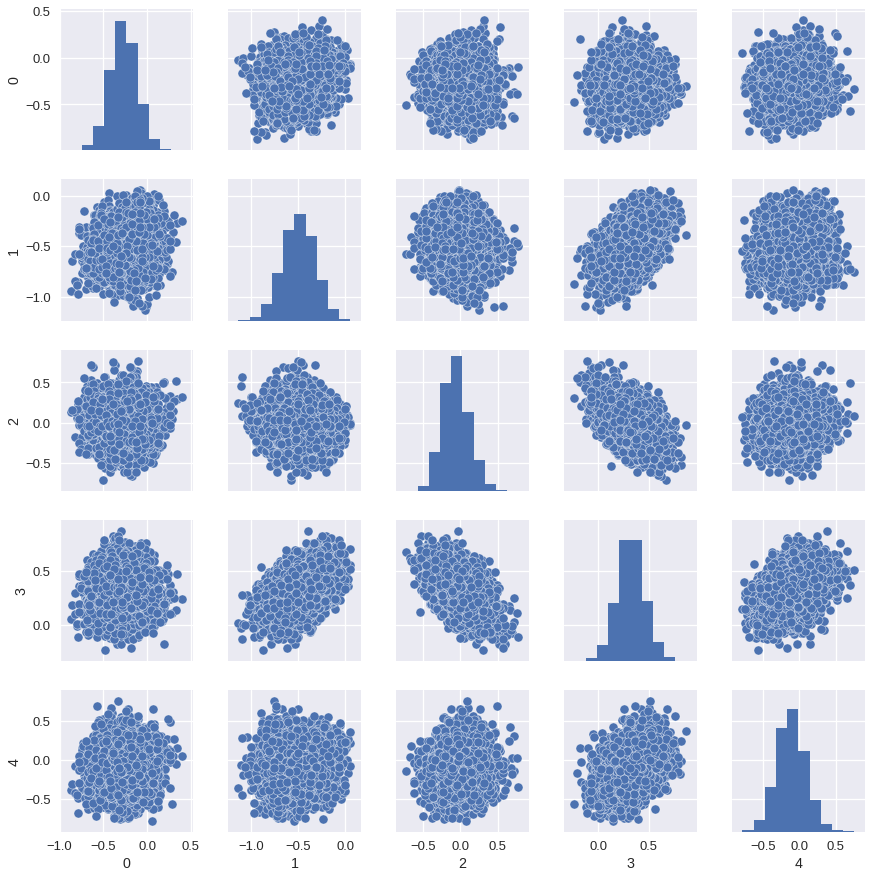

In [519]:
import pandas as pd
ae_encoder = Encoder(model)
z_vectors = ae_encoder.gen_fn(X_train)
df = pd.DataFrame(z_vectors[:, :5])
sns.pairplot(df)

Распределения походят на гауссовы, они выглядят плотно, всё в одном кластере. Также видно, что некоторые признаки получились зависимы (эллипсы лежат под углом к осям). По картинкам не очень понятно, можем ли мы проводить интерполяцию. Кажется, что подкручивать только одну латентную переменную точно не имеет смысла, так как она может быть зависима с другими, тогда изменение только её одной приведёт к неестественному изображению

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution q(z|x). Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick is implemented via the **GaussianSampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon$

The code for this layer taken from "recipes" folder of Lasagne github repo:

In [91]:
import GS

#reload(GS)

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average like it is in Lasagne recipes.

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

В рецепте лазаньи по ссылке выше матожидание и дисперсия для X вычисляются слоем сети из насемплированного Z. Для каждого Z получаются свои матожидания и дисперсии. То есть по одному распределению латентных переменных мы получаем не одно распределение X, а кучу. Это как-то не очень понятно. 

В своей реализации я попытался оценивать матожидание и дисперсию для расчёта правдоподобия из итоговых семплов X, полученных сетью из семплов Z. Далее первой идёт версия по рецепту, а потом моя.

In [264]:
def KL_divergence(mu, logsigma):
    return 0.5 * T.mean(-1 - 2 * logsigma + T.sqr(mu) + T.exp(2 * logsigma))

def log_likelihood(x, mu, logsigma):
    return -T.mean(logsigma +
                   0.5 * T.sqr(x - mu) / (T.exp(2 * logsigma)))

In [269]:
class VAE(object):
    def __init__(self, HU_encoder=2000, HU_decoder=2000, dimZ=1000, samples_count=10, eps=10**-10, 
                 relu_shift=100):
        self.eps = eps
        self.relu_shift = relu_shift
        self.HU_encoder = HU_encoder #you can play with this values
        self.HU_decoder = HU_decoder
        self.dimZ = dimZ #considering face reconstruction task, which size of representation seems reasonable?
        rec_shift = lambda a: \
                    lasagne.nonlinearities.rectify(a + self.relu_shift) - \
                    self.relu_shift
        # define the network
        # use ReLU for hidden layers' activations
        # GlorotUniform initialization for W
        # zero initialization for biases
        # it's also convenient to put sigmoid activation on output layer to get nice normalized pics

        self.l_input = lasagne.layers.InputLayer(shape=input_shape, input_var=input_X) 
        self.l_enc = lasagne.layers.DenseLayer(self.l_input,num_units=self.HU_encoder,
                                           nonlinearity=lasagne.nonlinearities.rectify,
                                           W=lasagne.init.GlorotUniform(), b=lasagne.init.Constant(0.),    
                                           name = "encoder")
        self.l_mu = lasagne.layers.DenseLayer(self.l_enc,num_units=self.dimZ,
                                           nonlinearity=None,
                                           W=lasagne.init.GlorotUniform(), b=lasagne.init.Constant(0.),    
                                           name = "mu")
        self.l_logsigma = lasagne.layers.DenseLayer(self.l_enc,num_units=self.dimZ,
                                           nonlinearity=rec_shift,
                                           W=lasagne.init.GlorotUniform(), b=lasagne.init.Constant(0.),    
                                           name = "logsigma")
        self.l_z = [
            GS.GaussianSampleLayer(self.l_mu, self.l_logsigma, name='Z{}'.format(index))
            for index in range(samples_count)
        ]
        # decoder
        self.l_dec = [0 for index in range(samples_count)]
        self.l_dec[0] = lasagne.layers.DenseLayer(
            self.l_z[0], num_units=self.HU_decoder,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),
            b=lasagne.init.Constant(0.),
            name='decoder',
        )
        W_dec_hid = self.l_dec[0].W
        b_dec_hid = self.l_dec[0].b
        for index in range(1, samples_count):
            self.l_dec[index] = lasagne.layers.DenseLayer(
                self.l_z[index], num_units=self.HU_decoder,
                nonlinearity=lasagne.nonlinearities.rectify,
                W=W_dec_hid,
                b=b_dec_hid,
                name='decoder',
            )
        # dec_mu
        self.l_dec_mu = [0 for index in range(samples_count)]
        self.l_dec_mu[0] = lasagne.layers.DenseLayer(
            self.l_dec[0], num_units=input_shape[1],
            nonlinearity=None,#lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform(),
            b=lasagne.init.Constant(0.),
            name='output',
        )
        W_dec_mu = self.l_dec_mu[0].W
        b_dec_mu = self.l_dec_mu[0].b
        for index in range(1, samples_count):
            self.l_dec_mu[index] = lasagne.layers.DenseLayer(
                self.l_dec[index], num_units=input_shape[1],
                nonlinearity=None,#lasagne.nonlinearities.sigmoid,
                W=W_dec_mu,
                b=b_dec_mu,
                name='dec_mu',
            )
        # dec_logsigma
        self.l_dec_logsigma = [0 for index in range(samples_count)]
        self.l_dec_logsigma[0] = lasagne.layers.DenseLayer(
            self.l_dec[0], num_units=input_shape[1],
            nonlinearity=rec_shift,#lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform(),
            b=lasagne.init.Constant(0.),
            name='output',
        )
        W_dec_logsigma = self.l_dec_logsigma[0].W
        b_dec_logsigma = self.l_dec_logsigma[0].b
        for index in range(1, samples_count):
            self.l_dec_logsigma[index] = lasagne.layers.DenseLayer(
                self.l_dec[index], num_units=input_shape[1],
                nonlinearity=rec_shift,#lasagne.nonlinearities.sigmoid,
                W=W_dec_logsigma,
                b=b_dec_logsigma,
                name='dec_mu',
            )
        self.l_x = [
            GS.GaussianSampleLayer(self.l_dec_mu[index], self.l_dec_logsigma[index], name='x{}'.format(index))
            for index in range(samples_count)
        ]
           
        
        self.l_out = lasagne.layers.ElemwiseSumLayer(self.l_x, coeffs = 1/samples_count) 
       
        # create prediction variable
        self.prediction = lasagne.layers.get_output(self.l_out, deterministic=False)
        self.test_prediction = lasagne.layers.get_output(self.l_out, deterministic=True)
        
        self.mu = lasagne.layers.get_output(self.l_mu)
        self.logsigma = lasagne.layers.get_output(self.l_logsigma)
        
        self.x_mu = lasagne.layers.get_output(self.l_dec_mu)
        self.x_logsigma = lasagne.layers.get_output(self.l_dec_logsigma)
        
        # create loss function
        self.loss = -sum(log_likelihood(input_X, x_mu, x_logsigma)
                         for x_mu, x_logsigma in zip(self.x_mu, self.x_logsigma))/samples_count +\
                    KL_divergence(self.mu, self.logsigma)        
        
        # create parameter update expressions
        self.params = lasagne.layers.get_all_params(self.l_out, trainable=True)
        self.updates = lasagne.updates.adam(self.loss, self.params, learning_rate=10**-4)

        # compile training function that updates parameters and returns training loss
        # this will take a while
        self.train_fn = theano.function([input_X], self.loss, updates=self.updates)
        self.test_fn = theano.function([input_X], self.test_prediction)
        self.val_fn = theano.function([input_X], self.loss)

And train the model:

Epoch 100 of 100 took 11.977s
  training loss (in-iteration):		-1.526602
  validation loss (in-iteration):		-1.528575


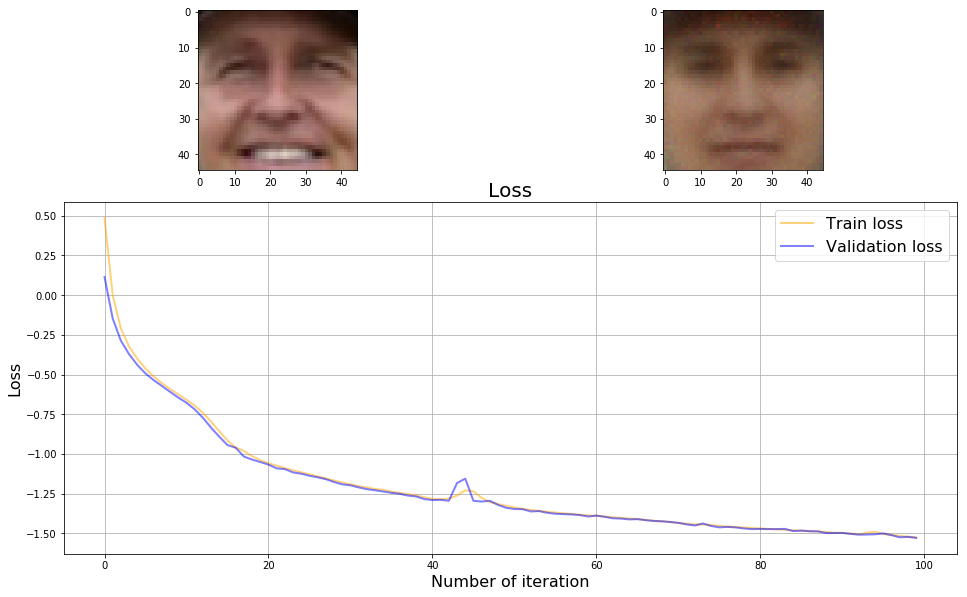

In [270]:
model_params = {'HU_encoder': 2000, 'HU_decoder': 2000, 'dimZ': 1000, 'samples_count': 10, 'eps': 10**-2,
                'relu_shift': 7}

num_epochs = 100
batch_size = 2000

vae_model = train_model(num_epochs=num_epochs, batch_size=batch_size, model=VAE(**model_params), 
                    )

Лосс ещё довольно уверенно убывает, запустим ещё обучение

Epoch 100 of 100 took 11.987s
  training loss (in-iteration):		-1.785482
  validation loss (in-iteration):		-1.778090


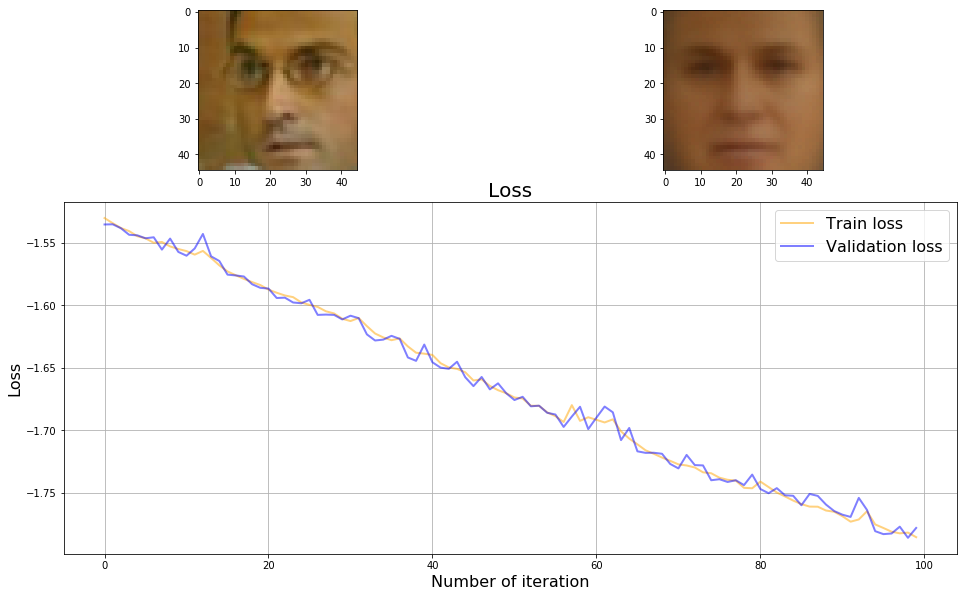

In [272]:
num_epochs = 100
batch_size = 2000

vae_model = train_model(num_epochs=num_epochs, batch_size=batch_size, model=vae_model, 
                    )

original             ae           vae


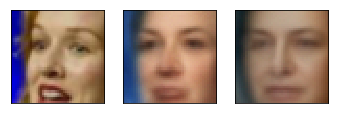

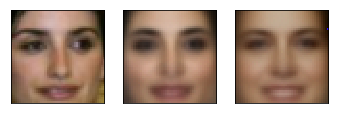

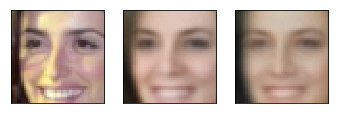

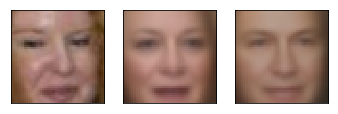

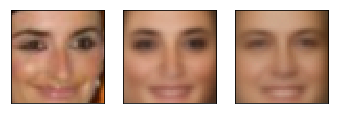

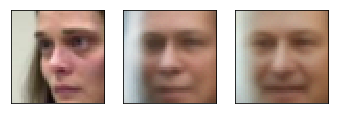

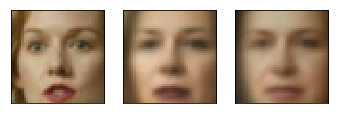

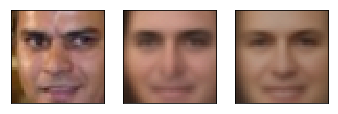

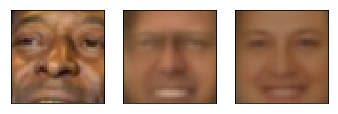

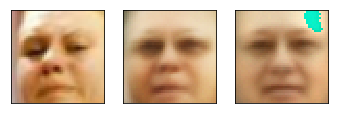

In [274]:
print('original             ae           vae')
for batch in iterate_minibatches(X_val[:10], 1):
    pred1 = ae_model.test_fn(batch)
    pred2 = vae_model.test_fn(batch)
    plot_gallery([batch[0], pred1, pred2], image_h, image_w, n_row=1, n_col=3)

Я отмечу, что VAE обучается с lr в 10 раз меньшим, чем при обучении AE (иначе не обучается). Для более корректного сравнения стоит ещё обучить VAE, пока лосс не выйдет на плато.

Попробуем оценивать матожидание и дисперсию для декодированных изображений по семплированной выборке.

In [275]:
def log_likelihood_sigma2(x, mu, sigma2):
    return -T.mean(0.5 * T.log(sigma2) +
                   0.5 * T.sqr(x - mu) / sigma2)

In [284]:
class SampledVAE(object):
    def __init__(self, HU_encoder=2000, HU_decoder=2000, dimZ=1000, samples_count=10, eps=10**-6, 
                 relu_shift=7):
        self.eps = eps
        self.relu_shift = relu_shift
        self.HU_encoder = HU_encoder #you can play with this values
        self.HU_decoder = HU_decoder
        self.dimZ = dimZ #considering face reconstruction task, which size of representation seems reasonable?
        rec_shift = lambda a: \
                    lasagne.nonlinearities.rectify(a + self.relu_shift) - \
                    self.relu_shift
        # define the network
        # use ReLU for hidden layers' activations
        # GlorotUniform initialization for W
        # zero initialization for biases
        # it's also convenient to put sigmoid activation on output layer to get nice normalized pics

        self.l_input = lasagne.layers.InputLayer(shape=input_shape, input_var=input_X) 
        self.l_enc = lasagne.layers.DenseLayer(self.l_input,num_units=self.HU_encoder,
                                           nonlinearity=lasagne.nonlinearities.rectify,
                                           W=lasagne.init.GlorotUniform(), b=lasagne.init.Constant(0.),    
                                           name = "encoder")
        self.l_mu = lasagne.layers.DenseLayer(self.l_enc,num_units=self.dimZ,
                                           nonlinearity=None,
                                           W=lasagne.init.GlorotUniform(), b=lasagne.init.Constant(0.),    
                                           name = "mu")
        self.l_logsigma = lasagne.layers.DenseLayer(self.l_enc,num_units=self.dimZ,
                                           nonlinearity=rec_shift,
                                           W=lasagne.init.GlorotUniform(), b=lasagne.init.Constant(0.),    
                                           name = "logsigma")
        self.l_z = [
            GS.GaussianSampleLayer(self.l_mu, self.l_logsigma, name='Z{}'.format(index))
            for index in range(samples_count)
        ]
        # decoder
        self.l_dec = [0 for index in range(samples_count)]
        self.l_dec[0] = lasagne.layers.DenseLayer(
            self.l_z[0], num_units=self.HU_decoder,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),
            b=lasagne.init.Constant(0.),
            name='decoder',
        )
        W_dec_hid = self.l_dec[0].W
        b_dec_hid = self.l_dec[0].b
        for index in range(1, samples_count):
            self.l_dec[index] = lasagne.layers.DenseLayer(
                self.l_z[index], num_units=self.HU_decoder,
                nonlinearity=lasagne.nonlinearities.rectify,
                W=W_dec_hid,
                b=b_dec_hid,
                name='decoder',
            )

        # x samples
        self.l_x = [0 for index in range(samples_count)]
        self.l_x[0] = lasagne.layers.DenseLayer(
            self.l_dec[0], num_units=input_shape[1],
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform(),
            b=lasagne.init.Constant(0.),
            name='x',
        )
        W_x = self.l_x[0].W
        b_x = self.l_x[0].b
        for index in range(1, samples_count):
            self.l_x[index] = lasagne.layers.DenseLayer(
                self.l_dec[index], num_units=input_shape[1],
                nonlinearity=lasagne.nonlinearities.sigmoid,
                W=W_x,
                b=b_x,
                name='x',
            )
           
        
        self.l_out = lasagne.layers.ElemwiseSumLayer(self.l_x, coeffs = 1/samples_count) 
        self.l_dev = [lasagne.layers.ElemwiseSumLayer([self.l_x[index], self.l_out], coeffs=[1, -1])
                      for index in range(samples_count)]
        self.l_dev2 = [lasagne.layers.ElemwiseMergeLayer([self.l_dev[index], self.l_dev[index]], merge_function=T.mul)
                       for index in range(samples_count)]
        self.l_x_sigma2 = lasagne.layers.ElemwiseSumLayer(self.l_dev2, coeffs = 1/samples_count) 
       
        # create prediction variable
        self.prediction = lasagne.layers.get_output(self.l_out, deterministic=False)
        self.test_prediction = lasagne.layers.get_output(self.l_out, deterministic=True)
        
        self.mu = lasagne.layers.get_output(self.l_mu)
        self.logsigma = lasagne.layers.get_output(self.l_logsigma)
        
        self.x_mu = lasagne.layers.get_output(self.l_out)
        self.x_sigma2 = lasagne.layers.get_output(self.l_x_sigma2)
        
        # create loss function
        self.loss = -log_likelihood_sigma2(input_X, self.x_mu, self.x_sigma2) +\
                    KL_divergence(self.mu, self.logsigma)        
        
        # create parameter update expressions
        self.params = lasagne.layers.get_all_params(self.l_out, trainable=True)
        self.updates = lasagne.updates.adam(self.loss, self.params, learning_rate=10**-4)

        # compile training function that updates parameters and returns training loss
        # this will take a while
        self.train_fn = theano.function([input_X], self.loss, updates=self.updates)
        self.test_fn = theano.function([input_X], self.test_prediction)
        self.val_fn = theano.function([input_X], self.loss)

Epoch 100 of 100 took 11.371s
  training loss (in-iteration):		-1.740369
  validation loss (in-iteration):		-1.729684


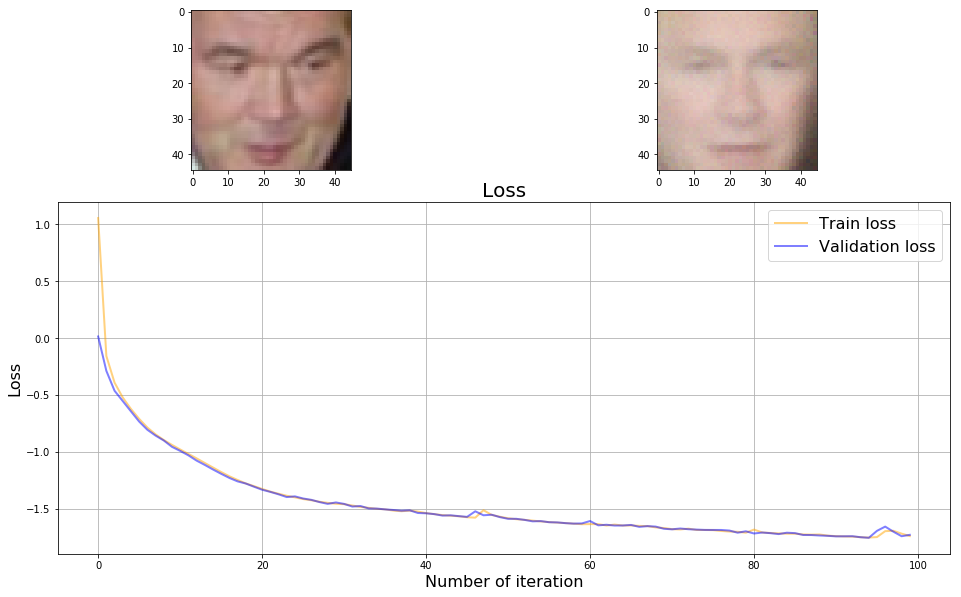

In [285]:
model_params = {'HU_encoder': 2000, 'HU_decoder': 2000, 'dimZ': 1000, 'samples_count': 10, 'eps': 10**-2,
                'relu_shift': 7}

num_epochs = 100
batch_size = 2000

sampled_vae_model = train_model(num_epochs=num_epochs, batch_size=batch_size, model=SampledVAE(**model_params), 
                    )

Epoch 100 of 100 took 11.345s
  training loss (in-iteration):		-1.920868
  validation loss (in-iteration):		-1.911885


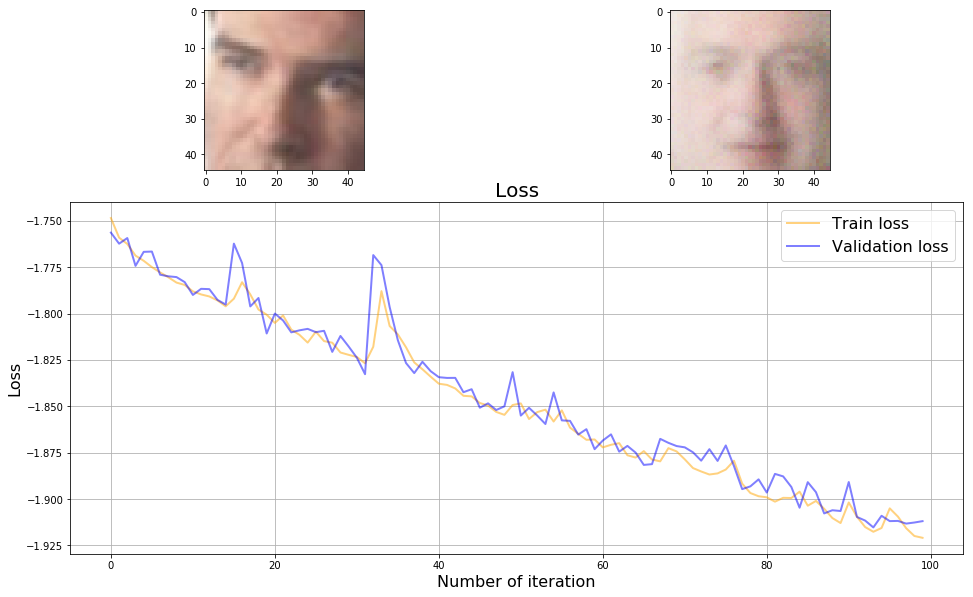

In [286]:
num_epochs = 100
batch_size = 2000

sampled_vae_model = train_model(num_epochs=num_epochs, batch_size=batch_size, model=sampled_vae_model, 
                    )

  original        ae        vae       sampled_vae


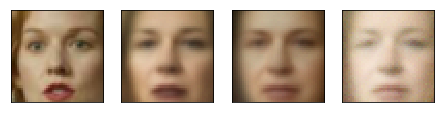

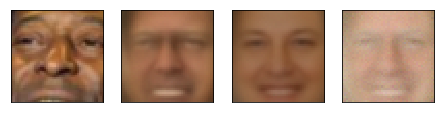

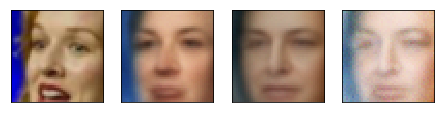

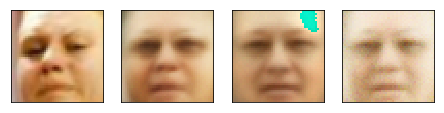

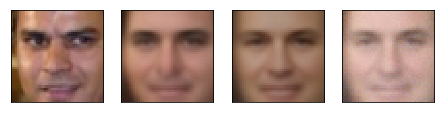

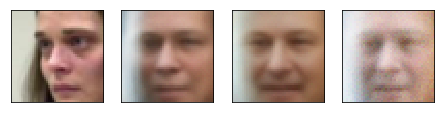

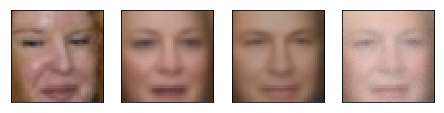

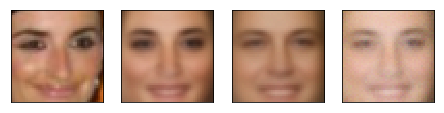

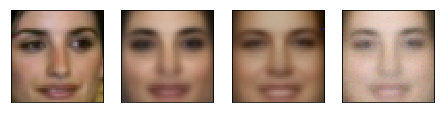

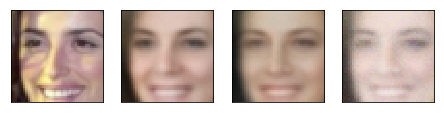

In [289]:
print('  original        ae        vae       sampled_vae')
for batch in iterate_minibatches(X_val[:10], 1):
    pred1 = ae_model.test_fn(batch)
    pred2 = vae_model.test_fn(batch)
    pred3 = sampled_vae_model.test_fn(batch)
    plot_gallery([batch[0], pred1, pred2, pred3], image_h, image_w, n_row=1, n_col=4)

Sampled VAE производит более блёклые картинки. В остальном, кажется, существенной разницы в картинках нет.

# Congrats!

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" column as a separate numpy vector and sort this vector.

In [313]:
smiling = attrs['Smiling']
sorted_data = data[np.argsort(smiling)]
sorted_data = np.float32(sorted_data) / 255
sorted_data = sorted_data.reshape((-1,X_train.shape[1]))

Sad

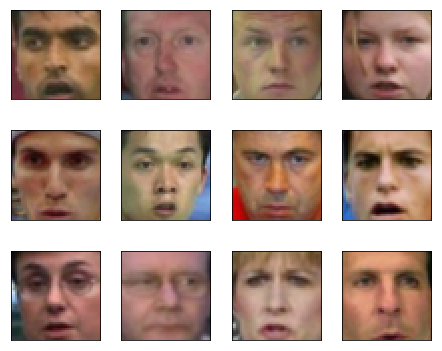

In [314]:
plot_gallery(sorted_data[:12], image_h, image_w, 3, 4)

Happy

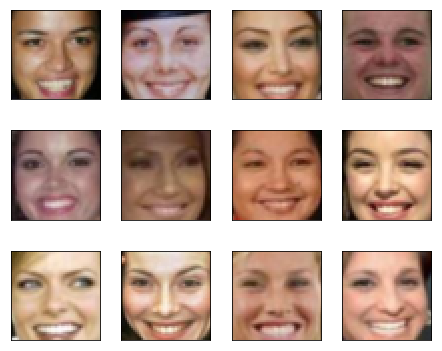

In [315]:
plot_gallery(sorted_data[-12:], image_h, image_w, 3, 4)

Some useful classes

In [321]:
class DecoderVAE(object):
    def __init__(self, model):
        self.HU_encoder = model.HU_encoder #you can play with this values
        self.HU_decoder = model.HU_decoder
        self.dimZ = model.dimZ #considering face reconstruction task, which size of representation seems reasonable?
        z_sample = T.matrix()

        # define the network
        # use ReLU for hidden layers' activations
        # GlorotUniform initialization for W
        # zero initialization for biases
        # it's also convenient to put sigmoid activation on output layer to get nice normalized pics
        self.l_z = lasagne.layers.InputLayer(shape=[None, self.dimZ], input_var=z_sample)
        self.l_dec = lasagne.layers.DenseLayer(self.l_z,num_units=self.HU_decoder,
                                           nonlinearity = lasagne.nonlinearities.rectify,
                                           W=model.l_dec[0].W, b=model.l_dec[0].b,    
                                           name = "hidden_decoder")
        if isinstance(model, VAE):
            layer = model.l_dec_mu[0]
        else:
            layer = model.l_x[0]
        self.l_out = lasagne.layers.DenseLayer(self.l_dec,num_units=input_shape[1],
                                           nonlinearity = lasagne.nonlinearities.sigmoid,
                                           W=layer.W, b=layer.b,    
                                           name = "output")

        # create prediction variable
        self.prediction = lasagne.layers.get_output(self.l_out)
        self.gen_fn = theano.function([z_sample], self.prediction)
        
class Encoder(object):
    def __init__(self, model):
        self.HU_encoder = model.HU_encoder #you can play with this values
        self.HU_decoder = model.HU_decoder
        self.dimZ = model.dimZ #considering face reconstruction task, which size of representation seems reasonable?
        z_sample = T.matrix()

        rec_shift = lambda a: \
                    lasagne.nonlinearities.rectify(a + self.relu_shift) - \
                    self.relu_shift
        # define the network
        # use ReLU for hidden layers' activations
        # GlorotUniform initialization for W
        # zero initialization for biases
        # it's also convenient to put sigmoid activation on output layer to get nice normalized pics

        self.l_input = lasagne.layers.InputLayer(shape=input_shape, input_var=input_X) 
        self.l_enc = lasagne.layers.DenseLayer(self.l_input,num_units=self.HU_encoder,
                                           nonlinearity=lasagne.nonlinearities.rectify,
                                           W=model.l_enc.W, b=model.l_enc.b,    
                                           name = "encoder")
        if isinstance(model, Model):
            layer = model.l_z
        else:
            layer = model.l_mu
        self.l_mu = lasagne.layers.DenseLayer(self.l_enc,num_units=self.dimZ,
                                           nonlinearity=None,
                                           W=layer.W, b=layer.b,
                                           name = "mu")

        # create prediction variable
        self.prediction = lasagne.layers.get_output(self.l_mu)
        self.gen_fn = theano.function([input_X], self.prediction)


In [322]:
vae_encoder = Encoder(vae_model)
vae_decoder = DecoderVAE(vae_model)

sampled_vae_encoder = Encoder(sampled_vae_model)
sampled_vae_decoder = DecoderVAE(sampled_vae_model)

ae_encoder = Encoder(ae_model)
ae_decoder = Decoder(ae_model)

Посмотрим на случайные лица для новых автоэнкодеров

Sampled VAE

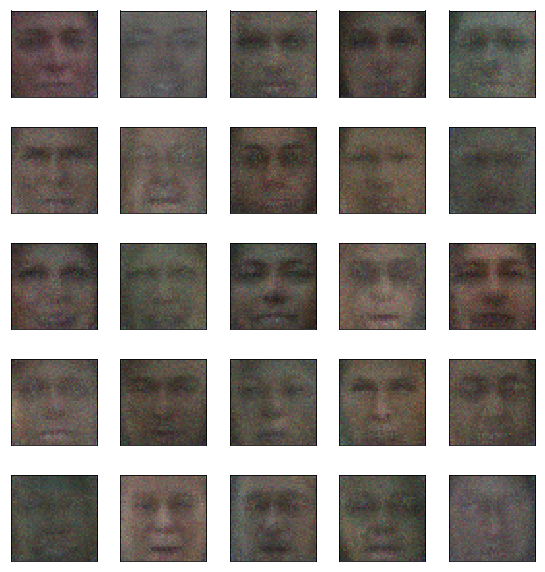

In [494]:
z = np.random.randn(25, dimZ)*0.5
output = sampled_vae_decoder.gen_fn(np.asarray(z, dtype=theano.config.floatX))
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

VAE

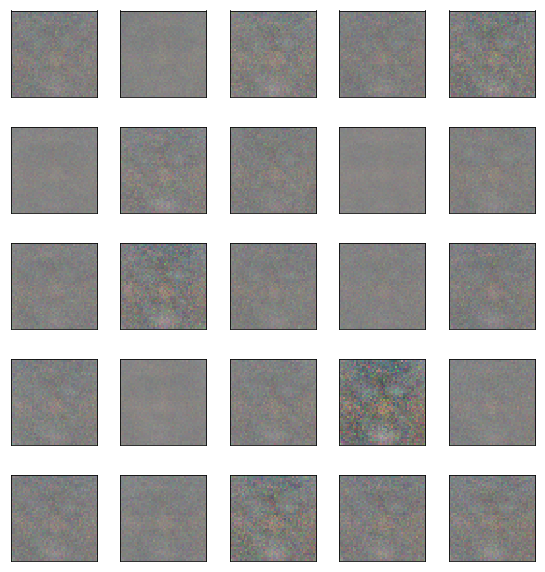

In [497]:
z = np.random.randn(25, dimZ)*0.5
output = vae_decoder.gen_fn(np.asarray(z, dtype=theano.config.floatX))
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

Вернёмся к увеселению

In [388]:
top_count = 50

In [389]:
happy_vae = np.mean(vae_encoder.gen_fn(sorted_data[-top_count:]), axis=0)
happy_sampled_vae = np.mean(sampled_vae_encoder.gen_fn(sorted_data[-top_count:]), axis=0)
happy_ae = np.mean(ae_encoder.gen_fn(sorted_data[-top_count:]), axis=0)

In [390]:
sad_vae = np.mean(vae_encoder.gen_fn(sorted_data[:top_count]), axis=0)
sad_sampled_vae = np.mean(sampled_vae_encoder.gen_fn(sorted_data[:top_count]), axis=0)
sad_ae = np.mean(ae_encoder.gen_fn(sorted_data[:top_count]), axis=0)

null vectors by
conventional      VAE      sampled_VAE


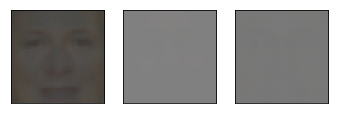

In [455]:
print('null vectors by')
print('conventional      VAE      sampled_VAE')
plot_gallery(np.array([ae_decoder.gen_fn([np.zeros(shape=1000)]), 
              vae_decoder.gen_fn([np.zeros(shape=1000)]),
              sampled_vae_decoder.gen_fn([np.zeros(shape=1000)])]),
             image_h, image_w, 1, 3)

happy vectors by
conventional      VAE      sampled_VAE


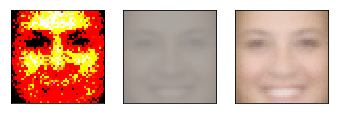

In [461]:
print('happy vectors by')
print('conventional      VAE      sampled_VAE')
plot_gallery(np.array([ae_decoder.gen_fn([happy_ae]), 
              vae_decoder.gen_fn([happy_vae]),
              sampled_vae_decoder.gen_fn([happy_sampled_vae])]),
             image_h, image_w, 1, 3)

sad vectors by
conventional      VAE      sampled_VAE


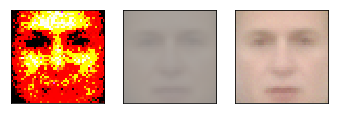

In [463]:
print('sad vectors by')
print('conventional      VAE      sampled_VAE')
plot_gallery(np.array([ae_decoder.gen_fn([sad_ae]), 
              vae_decoder.gen_fn([sad_vae]),
              sampled_vae_decoder.gen_fn([sad_sampled_vae])]),
             image_h, image_w, 1, 3)

happy - sad vectors by
conventional      VAE      sampled_VAE


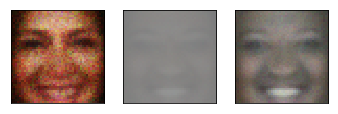

In [459]:
print('happy - sad vectors by')
print('conventional      VAE      sampled_VAE')
plot_gallery(np.array([ae_decoder.gen_fn([happy_ae - sad_ae]), 
              vae_decoder.gen_fn([happy_vae - sad_vae]),
              sampled_vae_decoder.gen_fn([happy_sampled_vae - sad_sampled_vae])]),
             image_h, image_w, 1, 3)

original sad faces


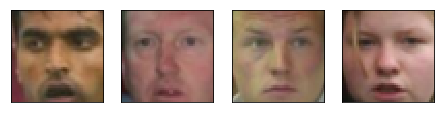

In [457]:
print('original sad faces')
plot_gallery(sorted_data[:4], image_h, image_w, 1, 4)

In [411]:
from sklearn.metrics.pairwise import cosine_similarity

In [478]:
def make_happier(image, encoder, decoder, happy, sad, max_alpha=1):
    z = encoder.gen_fn([image])
    x_z = decoder.gen_fn(z)
    diff = image - x_z
    happy_level = cosine_similarity(z.reshape(1, -1), happy.reshape(1, -1))[0][0]
    sad_level = cosine_similarity(z.reshape(1, -1), sad.reshape(1, -1))[0][0]
    happy_sad_level = cosine_similarity(z.reshape(1, -1), (happy - sad).reshape(1, -1))[0][0]
    print(happy_level, sad_level, happy_sad_level)
    ims = []
    for alpha in np.arange(0, max_alpha, max_alpha / 10):
        beta = 1 - alpha
        new_z = z + alpha * (happy  - sad)
        new_x_z = decoder.gen_fn(new_z)
        new_x = new_x_z + diff
        ims.append(new_x)
    z = encoder.gen_fn(ims[-1])
    happy_level = cosine_similarity(z.reshape(1, -1), happy.reshape(1, -1))[0][0]
    sad_level = cosine_similarity(z.reshape(1, -1), sad.reshape(1, -1))[0][0]
    happy_sad_level = cosine_similarity(z.reshape(1, -1), (happy - sad).reshape(1, -1))[0][0]
    print(happy_level, sad_level, happy_sad_level)
    plot_gallery(ims, image_h, image_w, 1, len(ims))

Sampled VAE

0.650088 0.746611 -0.0336253
0.796425 0.396133 0.616387


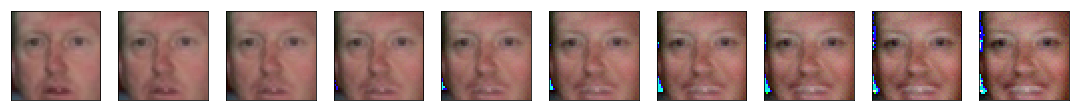

In [484]:
make_happier(sorted_data[1], sampled_vae_encoder, sampled_vae_decoder, happy_sampled_vae, sad_sampled_vae, 1.5)

0.617139 0.805535 -0.154631
0.840424 0.496885 0.550426


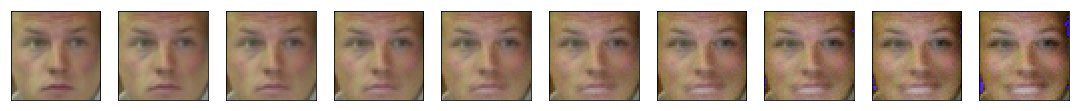

In [485]:
make_happier(sorted_data[2], sampled_vae_encoder, sampled_vae_decoder, happy_sampled_vae, sad_sampled_vae, 1.5)

0.692591 0.878352 -0.140986
0.883137 0.602665 0.476281


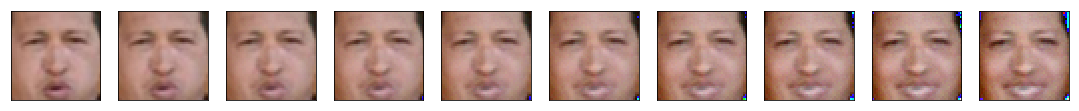

In [490]:
make_happier(sorted_data[100], sampled_vae_encoder, sampled_vae_decoder, happy_sampled_vae, sad_sampled_vae, 1.5)

VAE

0.690856 0.77036 -0.023493
0.895076 0.50876 0.595164


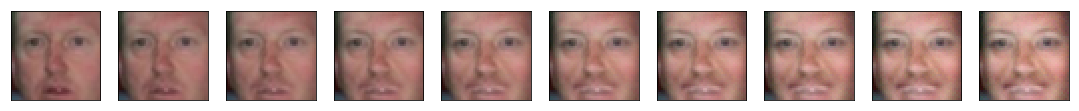

In [486]:
make_happier(sorted_data[1], vae_encoder, vae_decoder, happy_vae, sad_vae, 10)

0.645985 0.809745 -0.136292
0.892256 0.569614 0.513437


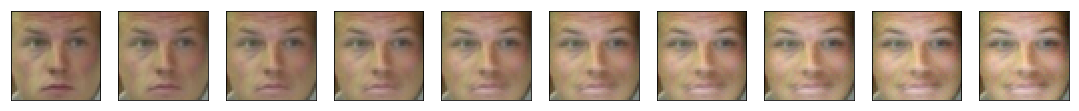

In [487]:
make_happier(sorted_data[2], vae_encoder, vae_decoder, happy_vae, sad_vae, 10)

0.685026 0.882428 -0.174887
0.915287 0.643052 0.451598


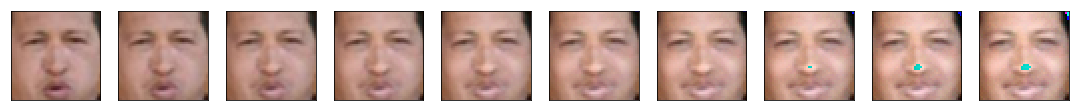

In [491]:
make_happier(sorted_data[100], vae_encoder, vae_decoder, happy_vae, sad_vae, 10)

AE

0.991324 0.993729 0.492533
0.992871 0.991632 0.52364


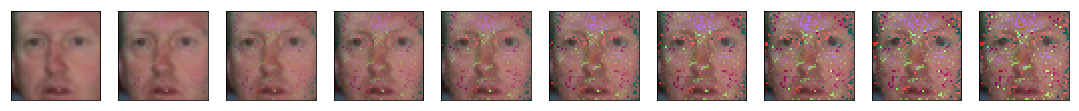

In [488]:
make_happier(sorted_data[1], ae_encoder, ae_decoder, happy_ae, sad_ae, 5)

0.991509 0.995422 0.480077
0.994139 0.994286 0.512765


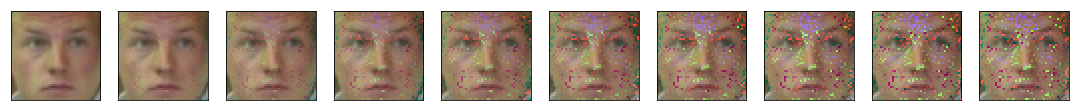

In [489]:
make_happier(sorted_data[2], ae_encoder, ae_decoder, happy_ae, sad_ae, 5)

0.993217 0.996838 0.483395
0.994115 0.995255 0.504497


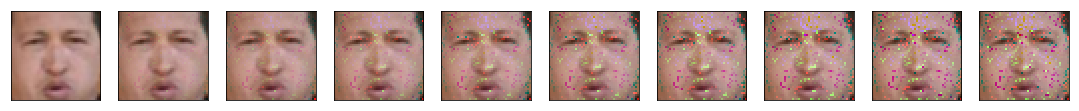

In [492]:
make_happier(sorted_data[100], ae_encoder, ae_decoder, happy_ae, sad_ae, 5)

С VAE всё выглядит гораздо лучше. У обычного автоенкодера латентное пространство не обладает необходимыми для нас свойствами линейности, поэтому в нём нельзя просто прибавить вектора радости и получить что-то дельное.

2) Take z-representations of those top images (you can do it only for positive or for both) and average them to find **"vector representation"** of the attribute.

3) Show how **"feature arithmetics"** works with representations of both VAE and conventional autoencoder. Show how to generate an image with preconditioned attribute. Take some sad faces and make them smiling.

4) (If you didn't manage to tune VAE, just show if it works for just AE.) Discuss the results.

<img src="linear.png" alt="linear">